### 1. Importing Required Modules & Libraries

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import parallel_coordinates
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import sklearn.cluster as cluster
import scipy.optimize as opt
import matplotlib.gridspec as gridspec 

### 2. Defining Functions

In [27]:
#Functions used for this projects mentioned below

def World_Bank_Reader(wb_file_name):
    """This is the docstring of the function World_Bank_Reader to read the data from the world bank csv
    file downloaded from the world bank site """
    
    #Reading data from the world bank csv file downloaded from the world bank website
    climate_change_df = pd.read_csv(wb_file_name, skiprows=4) 
    
    climate_change_df.drop(climate_change_df.columns[[-1]], axis=1, inplace=True)
    
    #Deriving data with Years as columns
    climate_year_df = climate_change_df[:]  
    
    #Deriving dataframe with country name as columns
    climate_country_df = climate_change_df.groupby(['Country Name']).aggregate('first').transpose()
    
    return climate_country_df, climate_year_df

### PART 1- Functions Normalization & Clustering

def norm_fun(data):
    """ Returns array normalised to [0,1]. Array can be a numpy array 
    or a column of a dataframe"""

    minimum_val = np.min(data)
    maximum_val = np.max(data)
    
    norm_data = (data-minimum_val)/(maximum_val-minimum_val)
    
    return norm_data


def normalize_df(norm_data):
    
    """ Returns all columns of the dataframe normalised to [0,1] with the 
    exception the first (containing the names)
    Calls function norm to do the normalisation of one column, but
    doing all in one function is also fine"""
    
    # iterate over all columns
    for cc_column in norm_data.columns[1:]:     # excluding the first column
        norm_data[cc_column] = norm_fun(norm_data[cc_column])
        
    return norm_data


def square_plot(data, xaxis, yaxis):
    
    """Produces a square plot of two columns of dataframe df using small circle 
    symbols."""
    
    plt.plot(data[xaxis], data[yaxis], "o", markersize=6)
    
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    

def heat_map(data):
    
    """Heat Map function for plotting the correlation data using the Correlation data recieved from the .Corr() function"""
    
    # Setting up the style
    plt.style.use('dark_background')
    
    # Using heatmap function from the SNS library for ploting heat map
    sns.heatmap(data, annot=True, cmap="YlGnBu")
    
    plt.show()
    

    
def K_mean (data, xaxis, yaxis, n, title):
    
    #kmeans set up the clusterer, n expected clusters
    kmeans = cluster.KMeans(n_clusters=n)

    #extract columns for fitting
    data_fit = data[[xaxis, yaxis]].copy()
    kmeans.fit(data_fit)     

    # extract labels and cluster centres
    cluster_labels = kmeans.labels_
    cluster_center = kmeans.cluster_centers_

    # plot using the labels to select colour
    col = ["blue", "red", "green", "magenta", "yellow", "orange"]
    
    # loop over the different labels
    for l in range(n):     
        plt.plot(data_fit[xaxis][cluster_labels==l], data_fit[yaxis][cluster_labels==l],
                 "o", markersize=8, color=col[l])
    
    # show cluster centres
    for iter_cent in range(n):
        xcluster, ycluster = cluster_center[iter_cent,:]
        plt.plot(xcluster, ycluster, "dk", markersize=12, color='white')
    
    plt.title (title)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    
  

    #PART 2-FITTING Functions defined below

def exp_growth(time, scale_val, growth_val):
    """ Calculating exponential_function 'xf' with scale value and growth value as free_parameters"""
    
    xf = scale_val*np.exp(growth_val*(time-1960)) 
    
    return xf
        

def logistics(time, scale_val, growth_val, time0):
    """ Calculating logistics_function 'lm' with scale_value & growth_value
    and time'0' as the triggering point as free parameter_values"""
    
    lf = scale_val/(1.0+np.exp(-growth_val*(time-time0)))
    
    return lf


def err_ranges(data, modl, parameter, sigma_val):
    
    """Calculates the upper_limits and lower_limits for the corresponding function.
    The parameter and sigma for single value. Function values are calculated for 
    all combination of +&- sigmas and the minimum and maximum is identified."""

    import itertools as iter
    
    # initiate arrays for lower/upper_limits
    lower_lim = modl(data, *parameter)
    upper_lim = lower_lim
    
    # holding upper and lower limits for parameters into a list
    uplow_lim = []
    
    #iteration
    for q,t in zip(parameter, sigma_val):
        pmin_val = q-t
        pmax_val = q+t
        uplow_lim.append((pmin_val, pmax_val))
        
    pmix_val = list(iter.product(*uplow_lim))
    
    for q in pmix_val:
        y_modl = modl(data, *q)
        lower_lim = np.minimum(lower_lim, y_modl)
        upper_lim = np.maximum(upper_lim, y_modl)
        
    return lower_lim, upper_lim


def fit_plot(data, xaxis, yaxis, fit_param, xlbl, ylbl, title, cl1, cl2):
    
    """ Simple Fitting plot by taking data & axis values with lables and color parameters"""
    
    plt.figure()
    plt.plot(data[xaxis], data[yaxis], label="Data", color=cl1)
    plt.plot(data[xaxis], data[fit_param], label="Fit", color=cl2)

    plt.legend()
    plt.title(title)
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

def fit_err_plot(data, low, up, xaxis, yaxis, fit_param, xlbl, ylbl, title, cl1, cl2, cl3):
    
    """ Plotting the Fitting plot with Error / confidence values obtained w.r.t the fitting parameters.
        This function takes, data with lower and upper limits with x & y axis parameters"""
    
    plt.figure()
    plt.title(title)
    plt.plot(data[xaxis], data[yaxis], label="Data", color=cl1)
    plt.plot(data[xaxis], data[fit_param], label="Fit", color=cl2)

    plt.fill_between(data[xaxis], low, up, alpha=0.9, color=cl3)
    plt.legend()
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()
    
def best_fit_plot(data, env_data, forcast, low, up, xaxis, yaxis, xlbl, ylbl, title, col1, col2, col3):
    """ Plotting the Best Fitting plot with Error / confidence values obtained w.r.t the fitting parameters.
        This function takes, data with lower & upper limits with x & y axis parameters. Also passing confidence
        value as the envelop for the fitted data"""
    
    plt.figure()
    plt.title(title)
    plt.plot(data[xaxis], data[yaxis], label=ylbl, color=col1)
    plt.plot(env_data, forcast, label="Forecast", color=col2)

    plt.fill_between(env_data, low, up, alpha=0.9, color=col3)
    plt.legend()
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.show()

In [28]:
#Functions used for this projects mentioned below

def read_csv_custom(wb_file_name):
    """This is the docstring of the function read_csv_custom to read the data from the world bank csv
    file downloaded from the world bank site
    
    
    Custom function to read a CSV file into a list of dictionaries without using Pandas.

    Parameters:
    - filepath (str): The path to the CSV file to be read.
    - delimiter (str, optional): Character used to separate values in the file. Defaults to ','.
    - skip_header (bool, optional): Whether to skip the first row (header) of the CSV file. 
      Defaults to False.

    Returns:
    - list of dict: A list where each element is a dictionary representing a row in the CSV file. 
      Column headers are used as keys.

    
    
    """
    
    #Reading data from the world bank csv file downloaded from the world bank website
    climate_change_df = pd.read_csv(wb_file_name, skiprows=4) 
    
    climate_change_df.drop(climate_change_df.columns[[-1]], axis=1, inplace=True)
    
    #Deriving data with Years as columns
    climate_year_df = climate_change_df[:]  
    
    #Deriving dataframe with country name as columns
    climate_country_df = climate_change_df.groupby(['Country Name']).aggregate('first').transpose()
    
    return climate_country_df, climate_year_df



def scale_column(data_column):
    """ Normalizes a single column to the range [0,1]."""

    min_value = data_column.min()
    max_value = data_column.max()
    
    scaled_output = (data_column - min_value) / (max_value - min_value)
    
    return scaled_output


def scale_dataframe(scale_data):
    
    """ Normalizes all columns of the DataFrame to the range [0,1], 
    excluding the first column (assumed to contain non-numeric data).
    It leverages the 'scale_column' function to perform the normalization
    of each column."""
    
    # Iterate over each column in the DataFrame, skipping the first
    for column_name in scale_data.columns[1:]:  # Skip the first column
        scale_data[column_name] = scale_column(scale_data[column_name])
        
    return scale_data





def plot_scatter(dataframe, x_column, y_column):
    
    """Generates a scatter plot comparing two columns from a DataFrame with 
    circle markers."""
    
    plt.scatter(dataframe[x_column], dataframe[y_column], marker='o', s=36)
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)

    

def correlation_heatmap(correlation_matrix):
    
    """Generates a heatmap visualization for the provided correlation matrix, typically derived from the DataFrame.corr() method."""
    
    # Apply a style theme for the plot background
    plt.style.use('ggplot')
    
    # Create a heatmap using seaborn library to visualize the correlation matrix
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    
    # Display the heatmap
    plt.show()
from sklearn import cluster
import matplotlib.pyplot as plt

def perform_kmeans_clustering(dataset, x_dim, y_dim, num_clusters, plot_title):
    
    # Set up the KMeans clustering algorithm with the specified number of clusters
    kmeans_clusterer = cluster.KMeans(n_clusters=num_clusters)

    # Select the relevant columns for clustering
    dataset_for_clustering = dataset[[x_dim, y_dim]].copy()
    kmeans_clusterer.fit(dataset_for_clustering)     

    # Extract the labels and centroids from the clustering algorithm
    labels = kmeans_clusterer.labels_
    centroids = kmeans_clusterer.cluster_centers_

    # Define a list of colors for plotting
    colors = ["cyan", "maroon", "lime", "purple", "gold", "silver"]

    # Plot the data points, colored by cluster label
    for label_id in range(num_clusters):     
        plt.scatter(dataset_for_clustering[x_dim][labels == label_id], 
                    dataset_for_clustering[y_dim][labels == label_id],
                    marker='o', s=64, color=colors[label_id], label=f'Cluster {label_id+1}')
    
    # Plot the centroids
    for centroid_id in range(num_clusters):
        centroid_x, centroid_y = centroids[centroid_id]
        plt.scatter(centroid_x, centroid_y, marker='x', s=100, color='white', edgecolor='black')

    plt.title(plot_title)
    plt.xlabel(x_dim)
    plt.ylabel(y_dim)
    plt.legend()
    plt.grid(True)
    plt.show()   

    

    
  

    #PART 2-FITTING Functions defined below

def calculate_exponential_growth(period, base_value, rate_of_increase):
    """ Computes exponential growth based on a base value and a growth rate. The calculation
    assumes the starting point is the year 1960."""

    growth_amount = base_value * np.exp(rate_of_increase * (period - 1960))
    
    return growth_amount

        

def compute_logistic_growth(epoch, capacity, rate, midpoint):
    """ Computes a logistic growth curve using the carrying capacity, growth rate, 
    and the midpoint as the inflection point of the curve."""

    logistic_value = capacity / (1 + np.exp(-rate * (epoch - midpoint)))
    
    return logistic_value


def err_ranges(data, modl, parameter, sigma_val):
    
    """Calculates the upper_limits and lower_limits for the corresponding function.
    The parameter and sigma for single value. Function values are calculated for 
    all combination of +&- sigmas and the minimum and maximum is identified."""

    import itertools as iter
    
    # initiate arrays for lower/upper_limits
    lower_lim = modl(data, *parameter)
    upper_lim = lower_lim
    
    # holding upper and lower limits for parameters into a list
    uplow_lim = []
    
    #iteration
    for q,t in zip(parameter, sigma_val):
        pmin_val = q-t
        pmax_val = q+t
        uplow_lim.append((pmin_val, pmax_val))
        
    pmix_val = list(iter.product(*uplow_lim))
    
    for q in pmix_val:
        y_modl = modl(data, *q)
        lower_lim = np.minimum(lower_lim, y_modl)
        upper_lim = np.maximum(upper_lim, y_modl)
        
    return lower_lim, upper_lim


def render_fit_visualization(dataset, horizontal_axis, vertical_axis, fitting_values, horizontal_label, vertical_label, graph_title, data_color, fit_color):
    
    """ Generates a plot to compare raw data against fitted values. Accepts the dataset, 
    specified axes for plotting, axis labels, plot title, and color specifications for the plot."""

    plt.figure()
    plt.plot(dataset[horizontal_axis], dataset[vertical_axis], label="Observed Data", color=data_color)
    plt.plot(dataset[horizontal_axis], dataset[fitting_values], label="Fitted Curve", color=fit_color)

    plt.legend()
    plt.title(graph_title)
    plt.xlabel(horizontal_label)
    plt.ylabel(vertical_label)
    plt.show()


def plot_fit_with_confidence(dataframe, lower_bound, upper_bound, horizontal_dim, vertical_dim, fit_series, label_x, label_y, graph_title, color_data, color_fit, color_confidence):
    
    """ Creates a plot displaying the fitted curve, the raw data, and the confidence interval around the fit.
        Inputs include the dataframe, confidence interval bounds, labels, and color specifications."""
    
    plt.figure()
    plt.title(graph_title)
    plt.plot(dataframe[horizontal_dim], dataframe[vertical_dim], label="Observed", color=color_data)
    plt.plot(dataframe[horizontal_dim], dataframe[fit_series], label="Model Fit", color=color_fit)

    plt.fill_between(dataframe[horizontal_dim], lower_bound, upper_bound, alpha=0.5, color=color_confidence, label="Confidence")
    plt.legend()
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show()

    
def generate_optimal_fit_visualization(dataset, prediction_data, forecast_values, confidence_lower, confidence_upper, horizontal_axis, vertical_axis, label_horizontal, label_vertical, plot_title, color_observed, color_forecast, color_confidence):
    """ Constructs a plot showcasing the optimal fit alongside forecasted values with a confidence interval. 
        The function accepts the dataset, confidence interval bounds, and various plot styling parameters."""

    plt.figure()
    plt.title(plot_title)
    plt.plot(dataset[horizontal_axis], dataset[vertical_axis], label=label_vertical, color=color_observed)
    plt.plot(prediction_data, forecast_values, label="Projected", color=color_forecast)

    plt.fill_between(prediction_data, confidence_lower, confidence_upper, alpha=0.5, color=color_confidence, label="Confidence Interval")
    plt.legend()
    plt.xlabel(label_horizontal)
    plt.ylabel(label_vertical)
    plt.show()


### 3. Defining Global Variables and Parameters

In [29]:
#Defining Global Variables & List used for the use of data manipulation

Total_urban_population= "SP.POP.TOTL"
CO2_emissions = "EN.ATM.CO2E.KT"
Renewable_energy_consumption  = "EG.FEC.RNEW.ZS"
Forest_area ='AG.LND.FRST.K2'
Total_greenhouse_gas_emissions='EN.ATM.GHGT.ZG'

urban_population="SP.URB.TOTL"
Electricity = "EG.ELC.RNWX.KH"
Foreign_invest = "EG.USE.PCAP.KG.OE"


#Indicator_replace list used to replace the Indicator code with an understandig words
Indicator_replace = {"SP.POP.TOTL":"Total_urban_population","EN.ATM.CO2E.KT":"CO2 emissions","EG.FEC.RNEW.ZS":"Renewable_energy",'AG.LND.FRST.K2':'Forest_area','EN.ATM.GHGT.ZG':'Total_greenhouse_gas_emissions',
                  "SP.URB.TOTL":"urban_population","EG.ELC.RNWX.KH":"Electricity","EG.USE.PCAP.KG.OE":"Foreign_invest"}

#Indicator_map used for maping the data-frame with corresponding indicators used by World bank data
Indicator_map = ["SP.POP.TOTL","EN.ATM.CO2E.KT","EG.FEC.RNEW.ZS","SP.URB.TOTL","EG.ELC.RNWX.KH","EG.USE.PCAP.KG.OE",'EN.ATM.GHGT.ZG','AG.LND.FRST.K2']

### 4. Reading Data Frames using Funtion From the World Bank Data File

In [30]:
#Assigning World Bank Data file name to a variable
wb_file_name = '/kaggle/input/world-bank-data-climate/API_19_DS2_en_csv_v2_6300757.csv'

In [31]:
#Using World Bank Reader function defined in the function section to generate 2x data frame as per the assignment requirement
country_df, year_df = read_csv_custom(wb_file_name)

###### 4.1 Returning Dataframe with Transposed format ( Countries as columns )

In [32]:
country_df.head()

Country Name,Afghanistan,Africa Eastern and Southern,Africa Western and Central,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Arab World,...,Uzbekistan,Vanuatu,"Venezuela, RB",Viet Nam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
Country Code,AFG,AFE,AFW,ALB,DZA,ASM,AND,AGO,ATG,ARB,...,UZB,VUT,VEN,VNM,VIR,PSE,WLD,YEM,ZMB,ZWE
Indicator Name,Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),...,Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population),Urban population (% of total population)
Indicator Code,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,...,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS,SP.URB.TOTL.IN.ZS
1960,8.401,14.56381,14.705391,30.705,30.51,66.211,58.45,10.435,39.656,31.022162,...,33.978,10.404,61.613,14.7,56.477,44.044,33.602516,9.1,18.145,12.608
1961,8.684,14.81141,15.090123,30.943,31.797,66.641,60.983,10.798,39.04,31.754677,...,34.238,10.583,62.875,15.031,57.864,44.734,34.089565,9.459,18.951,12.821


###### 4.2 Returning Dataframe with Original Format (Years as columns)

In [33]:
year_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.776,50.761000,50.746000,50.730000,50.715000,50.700000,...,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000,43.866000,44.052000
1,Aruba,ABW,Urban population,SP.URB.TOTL,27728.000,28330.000000,28764.000000,29157.000000,29505.000000,29802.000000,...,44228.000000,44588.000000,44943.000000,45297.000000,45648.000000,45999.000000,46351.000000,46574.000000,46734.000000,46891.000000
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,NaN,2.147858,1.520329,1.357042,1.186472,1.001576,...,0.826413,0.810669,0.793026,0.784578,0.771899,0.765986,0.762321,0.479958,0.342951,0.335381
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.000,55811.000000,56682.000000,57475.000000,58178.000000,58782.000000,...,102880.000000,103594.000000,104257.000000,104874.000000,105439.000000,105962.000000,106442.000000,106585.000000,106537.000000,106445.000000
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,2.179059,1.548572,1.389337,1.215721,1.032841,...,0.749301,0.691615,0.637959,0.590062,0.537296,0.494795,0.451970,0.134255,-0.045045,-0.086392


### 5. Re-arranging Data frame for the Analysis

#### 5.1 Arranging Data Frame

In [34]:
# Filtering out the required indicators for the anlysis from the previously defined Indicator Map list
year_df_new = year_df[year_df['Indicator Code'].isin(Indicator_map)]

In [35]:
# Replacing Not Identifiable Indicator code in to a known Identifiers
year_df_new["Indicator Code"].replace(Indicator_replace, inplace=True)

year_df_new = year_df_new.copy(deep=True) #To avoid warning related to the 'caveat'

In [36]:
# Droping Country Name  & Indicator Name as it is already defined
year_df_new = year_df_new.drop(['Country Code', 'Indicator Name'], axis=1, inplace=False)

In [37]:
country_data = year_df_new.reset_index()

In [38]:
#Normalizing the index for the easy analysis
country_data.drop(['index'], axis=1, inplace=True)

In [39]:
stat_data = country_data.groupby(['Country Name', 'Indicator Code']).aggregate('mean')

In [40]:
df_env_f = stat_data.stack().unstack(level=1)

stat_data2 = df_env_f.groupby(['Country Name']).aggregate('mean')

In [41]:
stat_data_orig = stat_data2.reset_index()

In [42]:
stat_data_orig

Indicator Code,Country Name,CO2 emissions,Electricity,Foreign_invest,Forest_area,Renewable_energy,Total_greenhouse_gas_emissions,Total_population,urban_population
0,Afghanistan,4.821062e+03,NaN,NaN,1.208440e+04,27.041563,11.476205,1.841010e+07,3.896487e+06
1,Africa Eastern and Southern,4.526406e+05,1.360800e+09,764.484376,4.896484e+06,63.329697,NaN,3.519201e+08,1.008653e+08
2,Africa Western and Central,1.539137e+05,1.075111e+08,564.938162,1.912740e+06,81.264337,NaN,2.397564e+08,8.588616e+07
3,Albania,3.881955e+03,0.000000e+00,747.961218,7.811928e+03,40.236129,-33.026241,2.713096e+06,1.138930e+06
4,Algeria,1.057612e+05,1.711111e+06,814.847841,1.777714e+04,0.319032,31.178656,2.591513e+07,1.512322e+07
...,...,...,...,...,...,...,...,...,...
260,West Bank and Gaza,NaN,NaN,NaN,9.582031e+01,17.249688,NaN,3.458736e+06,2.550753e+06
261,World,2.817335e+07,2.350456e+11,1585.774035,4.118018e+07,17.335888,16.022615,5.407576e+09,2.485763e+09
262,"Yemen, Rep.",1.595708e+04,0.000000e+00,203.683381,5.490000e+03,1.366774,109.671297,1.583325e+07,4.317867e+06
263,Zambia,3.320688e+03,0.000000e+00,713.107295,4.654279e+05,86.377097,36.032278,9.055473e+06,3.481922e+06


In [43]:
stat_data_orig.columns

Index(['Country Name', 'CO2 emissions', 'Electricity', 'Foreign_invest',
       'Forest_area', 'Renewable_energy', 'Total_greenhouse_gas_emissions',
       'Total_population', 'urban_population'],
      dtype='object', name='Indicator Code')

#### 5.2 Handling Null Values

In [44]:
# Handling the null values
stat_data_orig['CO2 emissions'].fillna(stat_data_orig['CO2 emissions'].mean(), inplace=True)
stat_data_orig['Electricity'].fillna(stat_data_orig['Electricity'].mean(), inplace=True)
stat_data_orig['Foreign_invest'].fillna(stat_data_orig['Foreign_invest'].mean(), inplace=True)
stat_data_orig['Renewable_energy'].fillna(stat_data_orig['Renewable_energy'].mean(), inplace=True)
stat_data_orig['Total_urban_population'].fillna(stat_data_orig['Total_urban_population'].mean(), inplace=True)
stat_data_orig['urban_population'].fillna(stat_data_orig['urban_population'].mean(), inplace=True)
stat_data_orig['Total_greenhouse_gas_emissions'].fillna(stat_data_orig['Total_greenhouse_gas_emissions'].mean(), inplace=True)
stat_data_orig['Forest_area'].fillna(stat_data_orig['Forest_area'].mean(), inplace=True)

In [45]:
stat_data_orig.isnull().any()

Indicator Code
Country Name                      False
CO2 emissions                     False
Electricity                       False
Foreign_invest                    False
Forest_area                       False
Renewable_energy                  False
Total_greenhouse_gas_emissions    False
Total_population                  False
urban_population                  False
dtype: bool

### 6. Normalization

###### 6.1 Checking the Statistics Parmeters on the Original Data

In [46]:
print(stat_data_orig.describe())

Indicator Code  CO2 emissions   Electricity  Foreign_invest   Forest_area  \
count            2.650000e+02  2.650000e+02      265.000000  2.650000e+02   
mean             1.023848e+06  1.018329e+10     1884.023297  1.655810e+06   
std              3.060533e+06  2.625936e+10     2137.508169  4.992984e+06   
min              8.680645e+00  0.000000e+00       12.495558  0.000000e+00   
25%              3.881955e+03  3.557778e+07      584.048121  3.622650e+03   
50%              4.181496e+04  1.468311e+09     1434.874957  3.847742e+04   
75%              6.065543e+05  1.018329e+10     2060.951105  3.325120e+05   
max              2.817335e+07  2.350456e+11    18278.542119  4.118018e+07   

Indicator Code  Renewable_energy  Total_greenhouse_gas_emissions  \
count                 265.000000                      265.000000   
mean                   31.049588                       39.929938   
std                    28.964216                      112.885960   
min                     0.000000  

###### 6.2 Finding the Correlation between Indicators on Original Data

In [47]:
print(stat_data_orig.columns)


Index(['Country Name', 'CO2 emissions', 'Electricity', 'Foreign_invest',
       'Forest_area', 'Renewable_energy', 'Total_greenhouse_gas_emissions',
       'Total_population', 'urban_population'],
      dtype='object', name='Indicator Code')


In [48]:
# data_corr = stat_data_orig.corr()  
# heat_map(data_corr)

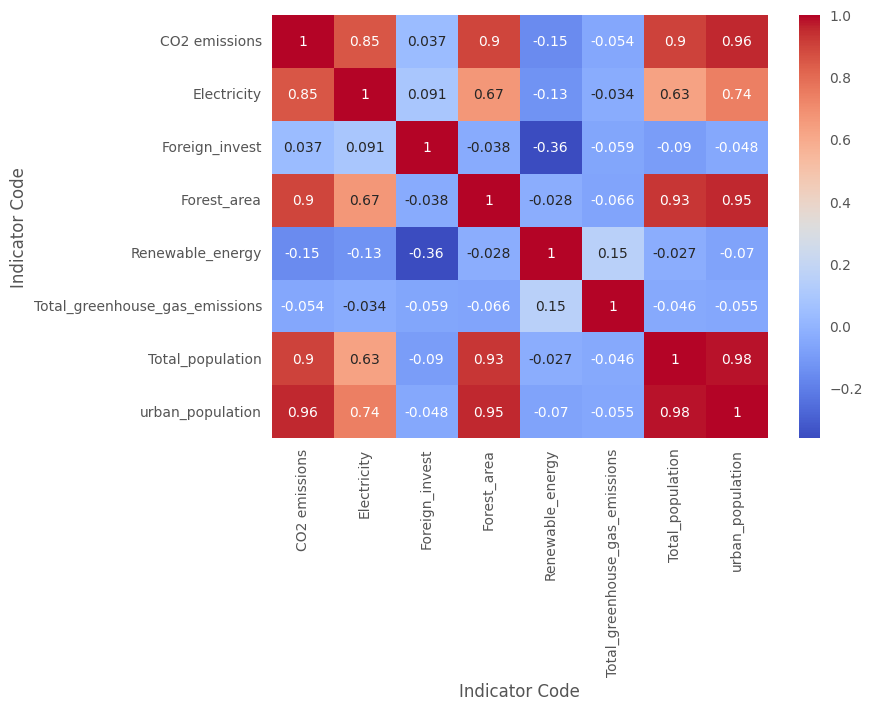

In [49]:
# Select only numeric columns for correlation
numeric_data = stat_data_orig.select_dtypes(include=[np.number])

# Calculate the correlation matrix
data_corr = numeric_data.corr()

# Assuming heat_map is a function you've defined to plot the correlation matrix
correlation_heatmap(data_corr)


###### 6.3 Normalizing the Data & Displaying the Correlation

In [52]:

stat_data_orig = normalize_df(stat_data_orig)

print(stat_data_orig.describe())

Indicator Code  CO2 emissions  Electricity  Foreign_invest  Forest_area  \
count              265.000000   265.000000      265.000000   265.000000   
mean                 0.036341     0.043325        0.102459     0.040209   
std                  0.108632     0.111720        0.117021     0.121247   
min                  0.000000     0.000000        0.000000     0.000000   
25%                  0.000137     0.000151        0.031290     0.000088   
50%                  0.001484     0.006247        0.077870     0.000934   
75%                  0.021529     0.043325        0.112146     0.008075   
max                  1.000000     1.000000        1.000000     1.000000   

Indicator Code  Renewable_energy  Total_greenhouse_gas_emissions  \
count                 265.000000                      265.000000   
mean                    0.321863                        0.063592   
std                     0.300246                        0.070600   
min                     0.000000                    

In [51]:
# # Normalizing the data for the good fitting & displaying the statistical parameters of the data frame
# # Normalize only the numeric columns of the DataFrame
# numeric_cols = stat_data_orig.select_dtypes(include=[np.number])
# stat_data_orig[numeric_cols.columns] = numeric_cols.apply(norm_fun)

# stat_data_orig = norm_fun(stat_data_orig)

# print(stat_data_orig.describe())

TypeError: '<=' not supported between instances of 'str' and 'float'

### 7. Pre-Processing - Plot a few combinations of attributes (using a function on GridSpec() )

We are looking into the possibility of different combinations of Indicators to make interesting clusters by using the Scatter Plot. From the below plots we understand that below parameters are good for making analyzable clusters 

#### 1. CO2 vs Electricity
#### 2. CO2 vs urban_population 
#### 3. CO2 vs Urban urban_population
#### 4. Urban urban_population Energy vs urban_population
#### 5. Forest vs Urban urban_population 
#### 6. Forest vs CO2

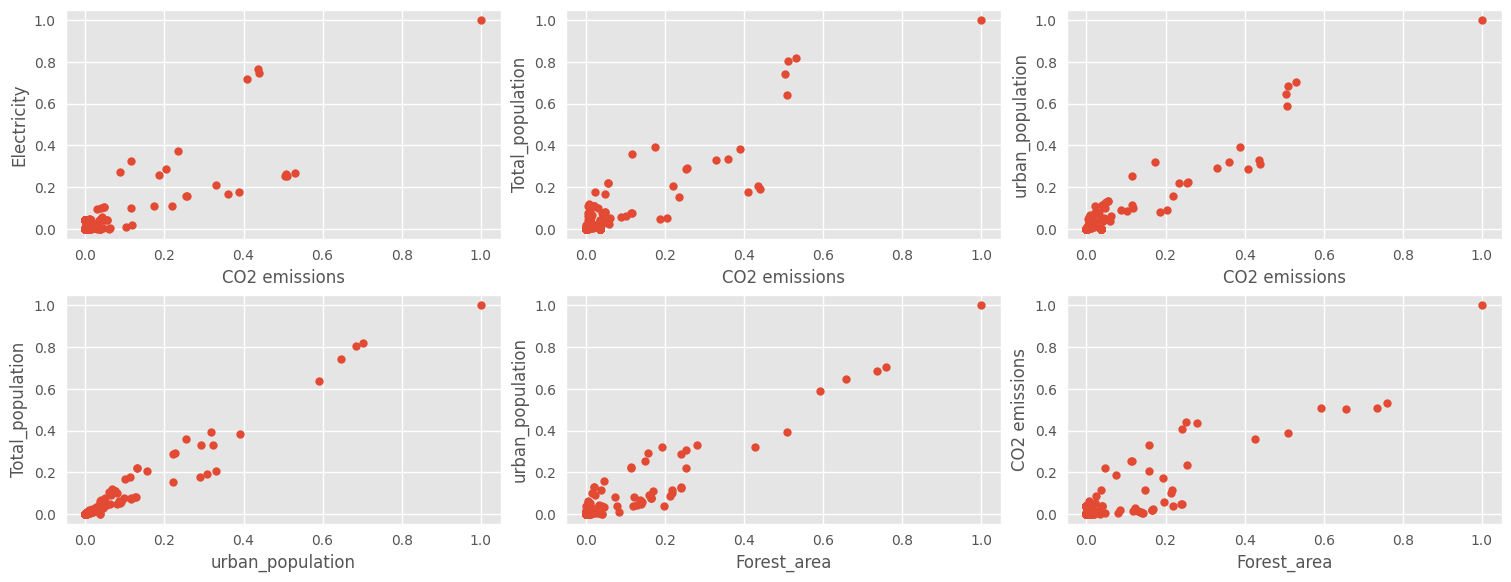

In [53]:
# Set up gridspec figure
fig = plt.figure(figsize=(15,8), constrained_layout=True)  # Setting the layout size to print it on the A4 Sheet

# Setting the Columns & Rows to the Grid Spec object
gs = fig.add_gridspec(nrows=3, ncols=3) 

ax1 = fig.add_subplot(gs[0,0])
#ax1.set_axis_off()

square_plot(stat_data_orig, "CO2 emissions", "Electricity")

ax2 = fig.add_subplot(gs[0,1])
square_plot(stat_data_orig, "CO2 emissions", "Total_urban_population")

ax3 = fig.add_subplot(gs[0,2])
square_plot(stat_data_orig, "CO2 emissions", "urban_population")


ax4 = fig.add_subplot(gs[1,0])
square_plot(stat_data_orig, "urban_population", "Total_urban_population")


ax5 = fig.add_subplot(gs[1,1])
square_plot(stat_data_orig, "Forest_area", "urban_population")

ax6 = fig.add_subplot(gs[1,2])
square_plot(stat_data_orig, "Forest_area", "CO2 emissions")






### 8. Clustering Using K-Means Algorithm and Displaying Cluster Membership

 From the above plots, we understand that 6 different plots are providing closer clusering. Using pre-defined custom function of K-means to find the clusters on the selected indicators. Here we are choosing cluster number as 4 for the clustering with reference to the above pre-processing step

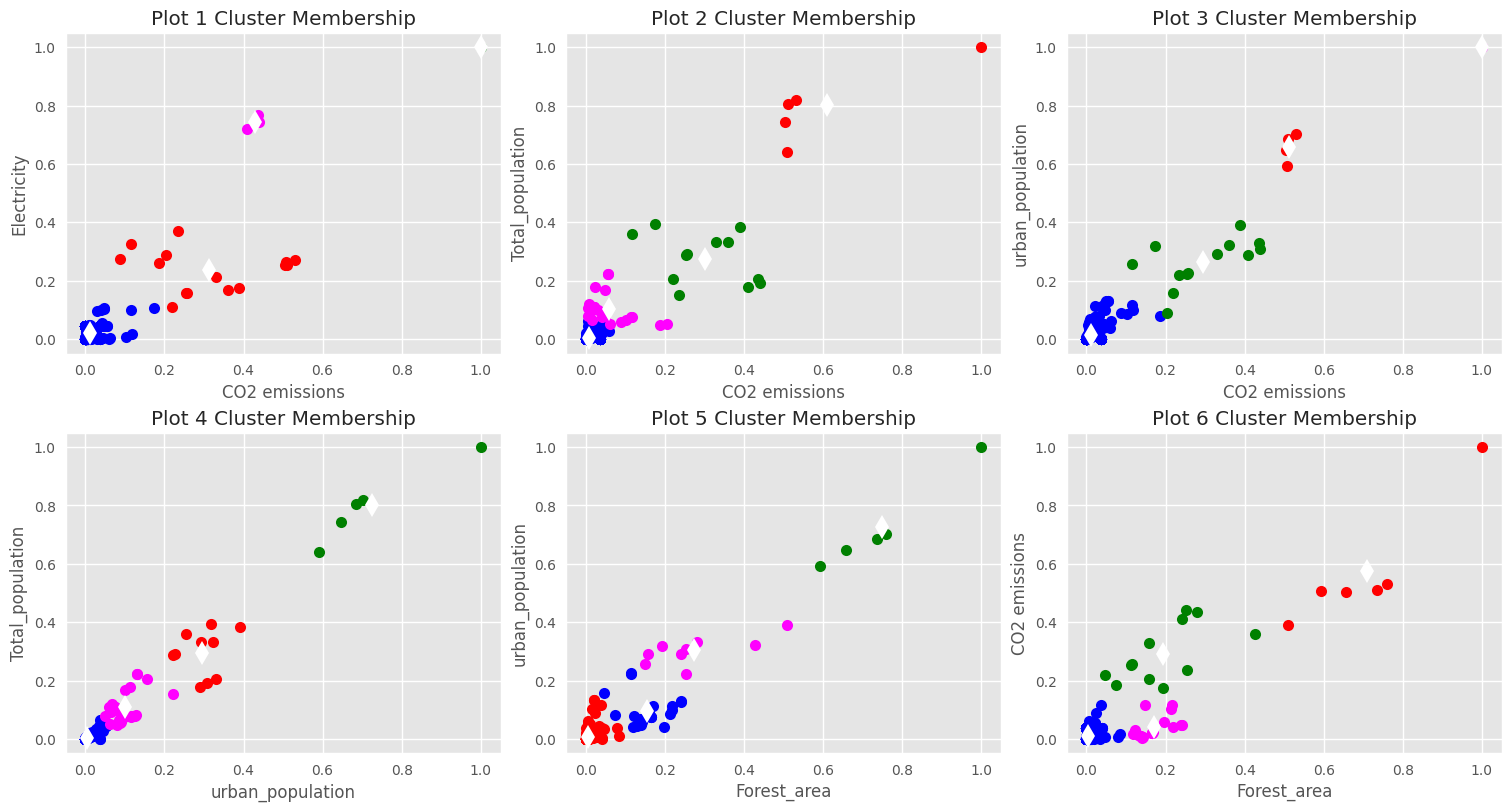

In [54]:
# Set up gridspec figure
fig = plt.figure(figsize=(15, 8), constrained_layout=True)  # Setting the layout size to print it on the A4 Sheet

# Setting the Columns & Rows to the Grid Spec object
gs = fig.add_gridspec(nrows=2, ncols=3) 
ax1 = fig.add_subplot(gs[0,0])
#ax1.set_axis_off()
K_mean (stat_data_orig,"CO2 emissions", "Electricity", 4, "Plot 1 Cluster Membership")

ax2 = fig.add_subplot(gs[0,1])
K_mean (stat_data_orig,"CO2 emissions", "Total_urban_population", 4, "Plot 2 Cluster Membership")

ax3 = fig.add_subplot(gs[0,2])
K_mean (stat_data_orig,"CO2 emissions", "urban_population", 4, "Plot 3 Cluster Membership")


ax4 = fig.add_subplot(gs[1,0])
K_mean (stat_data_orig,"urban_population", "Total_urban_population", 4, "Plot 4 Cluster Membership")


ax5 = fig.add_subplot(gs[1,1])
K_mean (stat_data_orig,"Forest_area", "urban_population", 4, "Plot 5 Cluster Membership")


ax6 = fig.add_subplot(gs[1,2])
K_mean (stat_data_orig,"Forest_area", "CO2 emissions", 4, "Plot 6 Cluster Membership")

### 9. Analysis & Findings on Clustering Data

Compare some results and showing our findings

Plot 1: Cluster Membership vs. Electricity Consumption

The x-axis represents normalized CO2 emissions, while the y-axis represents normalized electricity consumption.
Data points are color-coded to represent different clusters.
It appears that there are at least three clusters indicated by different colors (blue, green, and a few in red).
The blue cluster is concentrated at lower CO2 emissions and lower electricity consumption, possibly indicating countries with lower industrial activity or smaller economies.
The green cluster has higher values of both CO2 emissions and electricity consumption, likely representing more industrialized or developed countries.
The red points, which may represent outliers or another distinct cluster, show high electricity consumption but vary in CO2 emissions.
Plot 2: Cluster Membership vs. Total urban_population

The y-axis now represents normalized total urban_population.
Similar clustering pattern with blue, green, and red points.
The blue cluster generally has low CO2 emissions and a smaller urban_population, which could indicate smaller or less industrialized countries.
The green cluster has higher CO2 emissions and a range of urban_population values, suggesting these might be more industrialized countries with varying urban_population sizes.
The red points again appear to represent outliers or a separate cluster with higher urban_population numbers but varying levels of CO2 emissions, possibly indicating countries with high urban_population density but varying levels of industrialization.
Plot 3: Cluster Membership vs. Urban urban_population

The y-axis represents the normalized urban urban_population.
The blue cluster shows low CO2 emissions and a smaller urban urban_population, which could indicate countries with a smaller urban development or a large rural urban_population.
The green cluster has higher CO2 emissions and urban urban_population, suggesting more urbanized and possibly developed countries.
The red points are few and show a range of CO2 emissions and urban urban_population, which could be countries in transition or with unique characteristics different from the main clusters.


Plot 4: Cluster Membership vs. Urban urban_population

The x-axis represents the normalized urban urban_population, while the y-axis represents the normalized total urban_population.
The clusters are color-coded, likely representing different groups based on the urban and total urban_population characteristics.
The blue cluster is concentrated at lower values for both urban and total urban_population, possibly indicating less urbanized countries with smaller urban_populations.
The green cluster is in the mid-range for both urban_populations, suggesting countries with moderate levels of urbanization and urban_population sizes.
The red points, potentially outliers or a separate cluster, show high total urban_populations but vary in urban urban_population, indicating countries with large urban_populations that may have significant rural urban_populations as well.


Plot 5: Cluster Membership vs. Forest Area

The x-axis represents normalized forest area, while the y-axis represents the normalized urban urban_population.
The clustering pattern is somewhat similar to the previous plots with blue, green, and red points.
The blue cluster shows countries with smaller forest areas and urban urban_populations, which could indicate smaller or developing countries with limited forest coverage and urbanization.
The green cluster includes countries with moderate forest areas and urban urban_populations, suggesting a balance between urban development and forest conservation.
The red points again appear as outliers or a separate cluster with larger forest areas but varying urban urban_populations, which could be countries with significant natural forest coverage and varying degrees of urbanization.
Plot 6: Cluster Membership vs. Forest Area and CO2 Emissions

The x-axis represents normalized forest area, and the y-axis represents normalized CO2 emissions.
The blue cluster with low forest area and CO2 emissions could indicate countries with limited industrial activity and smaller forest areas.
The green cluster with moderate forest areas and CO2 emissions might represent countries that maintain a balance between industrial activity and environmental conservation.
The red points that are outliers or a separate cluster with high CO2 emissions and varying forest areas might suggest heavily industrialized countries with significant CO2 emissions and different levels of forest area, possibly due to varying environmental policies and geographical conditions.
General Findings Across All Plots:

CO2 emissions seem to be a significant factor in the clustering, with a clear gradient from low to high emissions observed.
The blue cluster consistently appears at the lower end of CO2 emissions across all plots, suggesting these countries have lower emissions and consumption or urban_population metrics.
The green cluster suggests a group of countries with higher emissions potentially linked to higher electricity usage, total urban_population, and urban urban_population.
Outliers or a separate cluster represented in red are less consistent in their positioning, suggesting these countries may have unique or mixed characteristics not wholly captured by the clustering process.


There appears to be a consistent clustering pattern across different plots, which might be indicative of underlying socio-economic and environmental factors.
The blue and green clusters suggest groups of countries with varying degrees of urbanization, forest area, and CO2 emissions.
The red cluster represents countries with potentially high urban_population sizes or significant environmental factors that set them apart from the other clusters.
The plots could be indicative of developmental stages, environmental conservation efforts, and the impact of urban_population on CO2 emissions and forest areas.
Analysis:

The clustering might reflect distinct developmental paths, with some countries prioritizing urban growth and others focusing on environmental conservation.
Outliers may require closer examination to understand the factors contributing to their unique cluster characteristics.
These visualizations can provide insights for targeted policy-making, especially concerning urban development, environmental sustainability, and their relationship with CO2 emissions.








Analysis:

The clustering reveals potential economic and developmental patterns, with clear distinctions between lower and higher emission countries.
The consistency of the clusters across different y-axes suggests that these groupings reflect broader socio-economic trends.
The outliers or the red cluster could warrant further investigation to understand why they differ from the main clusters.
These plots could be useful for policymakers to identify and compare countries with similar characteristics and to tailor environmental and development policies accordingly.





# 10. Fitting & Prediction ( till the year 2050)

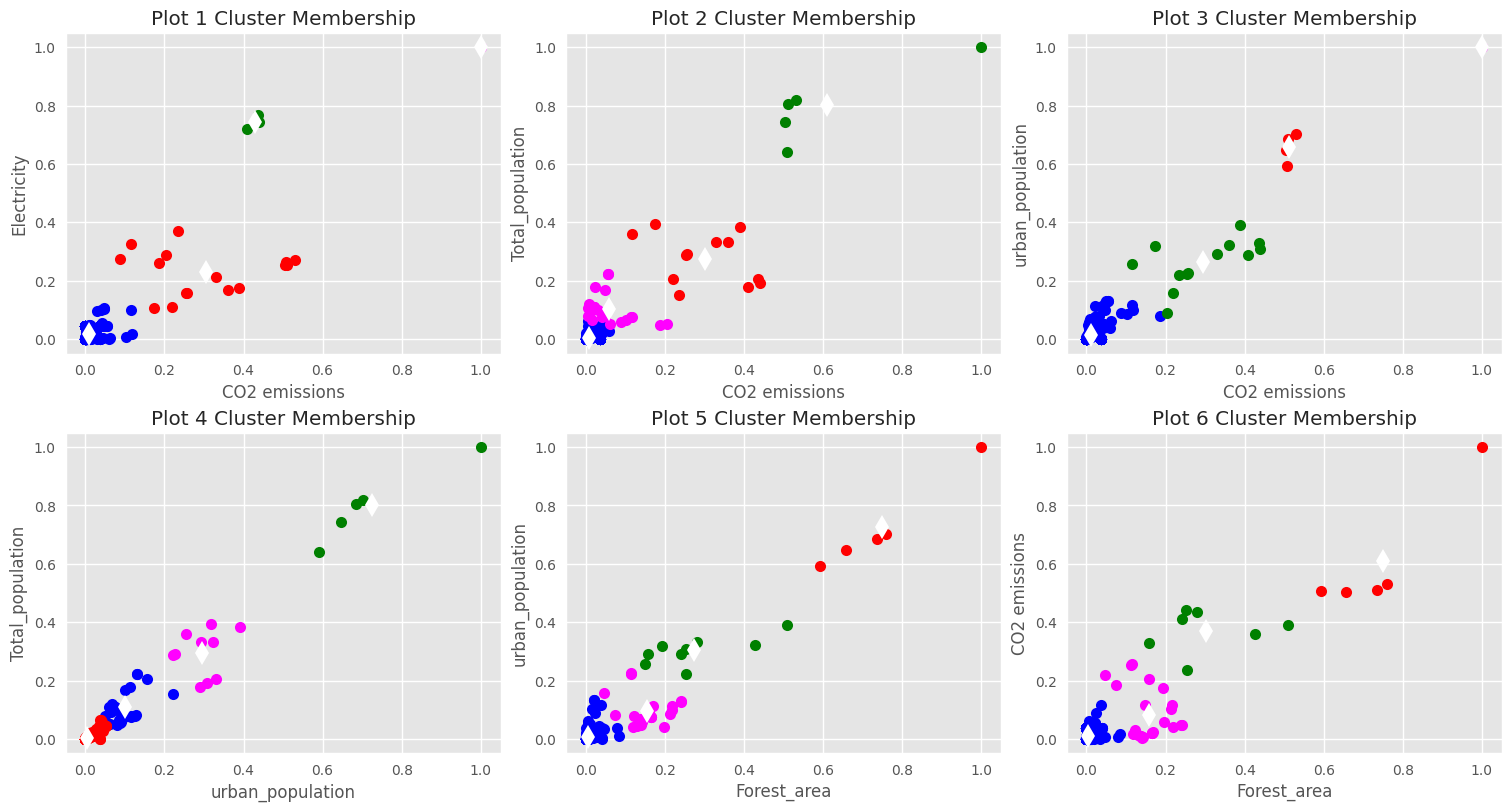

In [55]:
# Set up gridspec figure
fig = plt.figure(figsize=(15, 8), constrained_layout=True)  # Setting the layout size to print it on the A4 Sheet

# Setting the Columns & Rows to the Grid Spec object
gs = fig.add_gridspec(nrows=2, ncols=3) 
ax1 = fig.add_subplot(gs[0,0])
#ax1.set_axis_off()
K_mean (stat_data_orig,"CO2 emissions", "Electricity", 4, "Plot 1 Cluster Membership")

ax2 = fig.add_subplot(gs[0,1])
K_mean (stat_data_orig,"CO2 emissions", "Total_urban_population", 4, "Plot 2 Cluster Membership")

ax3 = fig.add_subplot(gs[0,2])
K_mean (stat_data_orig,"CO2 emissions", "urban_population", 4, "Plot 3 Cluster Membership")


ax4 = fig.add_subplot(gs[1,0])
K_mean (stat_data_orig,"urban_population", "Total_urban_population", 4, "Plot 4 Cluster Membership")


ax5 = fig.add_subplot(gs[1,1])
K_mean (stat_data_orig,"Forest_area", "urban_population", 4, "Plot 5 Cluster Membership")


ax6 = fig.add_subplot(gs[1,2])
K_mean (stat_data_orig,"Forest_area", "CO2 emissions", 4, "Plot 6 Cluster Membership")

- Step-1 Here we are using the Time series data of three countries ( North america,Saudi,British islands ) against the urban_population from the year between 1960 to 2022. Since both are showing highest urban_population growth over the years.


- Step-2 For the fitting of the data we are using the curve_fit function and generating the model. 


- Step-3 We will use two modelling scheme here. Using exponential growth and logistic function. 


- Step-4 We will use Both models for the prediction


- Step-5 Using the Error_range function, we will find out the limits and confidence ranges of both the predictions


- Step-6 Finally we will plot the Best Fitted Model with predictions and confidence ranges.

### 10.1 Generating the Time series data of India and China

In [70]:
# Extracting urban_population data of India & China from the world bank data frame using pandas data frame slicing

ur_pop_stat_can = df_env_f.loc[['Aruba'], ['urban_population']]

ur_pop_stat_chn = df_env_f.loc[['China'], ['urban_population']]

ur_pop_stat_it= df_env_f.loc[['India'], ['urban_population']]
# Removing the indexing for the time series analysis
ur_pop_stat_can = ur_pop_stat_can.reset_index()
ur_pop_stat_chn = ur_pop_stat_chn.reset_index()
ur_pop_stat_it = ur_pop_stat_it.reset_index()
# Renaming the default column name to 'Years'

ur_pop_stat_can.rename({'level_1':'Years'}, axis=1, inplace=True)
ur_pop_stat_chn.rename({'level_1':'Years'}, axis=1, inplace=True)
ur_pop_stat_it.rename({'level_1':'Years'}, axis=1, inplace=True)


### 10.2 Finding the Year when the urban_population Growth Start Increasing Exponentially to Define the model range

In [71]:
ur_pop_stat_can

Indicator Code,Country Name,Years,urban_population
0,Aruba,1960,27728.0
1,Aruba,1961,28330.0
2,Aruba,1962,28764.0
3,Aruba,1963,29157.0
4,Aruba,1964,29505.0
...,...,...,...
58,Aruba,2018,45999.0
59,Aruba,2019,46351.0
60,Aruba,2020,46574.0
61,Aruba,2021,46734.0


From the below checking, we can see that the urban_population has a rapid growth on the year 1985 to 2000. The urban_population has an increase of 270 Million. This makes the urban_population chart hitting on the 1 Billion Mark from 780 Million. So we will use the model range starting year as 1985

In [72]:
ur_pop_stat_can[['urban_population', 'Years']].values[25]  #urban_population in 1985

array([32494.0, '1985'], dtype=object)

In [73]:
ur_pop_stat_can[['urban_population', 'Years']].values[40]   #urban_population in 2000

array([41625.0, '2000'], dtype=object)

### 10.3 Converting World Bank Data values from String to Numeric

In [79]:
#Converting String to Numeric (as the data that have extracted data from the CSV considered as the String)

ur_pop_stat_can['urban_population'] = ur_pop_stat_can['urban_population'].astype(int)

ur_pop_stat_can['Years'] = ur_pop_stat_can['Years'].astype(int)

ur_pop_stat_chn['urban_population'] = ur_pop_stat_chn['urban_population'].astype(int) 

ur_pop_stat_chn['Years'] = ur_pop_stat_chn['Years'].astype(int)
ur_pop_stat_it['urban_population'] = ur_pop_stat_chn['urban_population'].astype(int) 

ur_pop_stat_it['Years'] = ur_pop_stat_chn['Years'].astype(int)


### 10.4 Fitting with  Exponential function Model & Forcasting with Uncertainity values

#### 10.4.1 Fitting using Exponential Function with Default Parameters & Values

In [80]:
# fit exponential growth with default parameters

ur_popt, co_var = opt.curve_fit(exp_growth, ur_pop_stat_can["Years"], ur_pop_stat_can["urban_population"])


In [81]:
# use *ur_popt to pass on the fit parameters used for the modeling

ur_pop_stat_can["pop_exp"] = exp_growth(ur_pop_stat_can["Years"], *ur_popt)


Exponential Fit parameter [2.90046063e-15 1.00000000e+00]


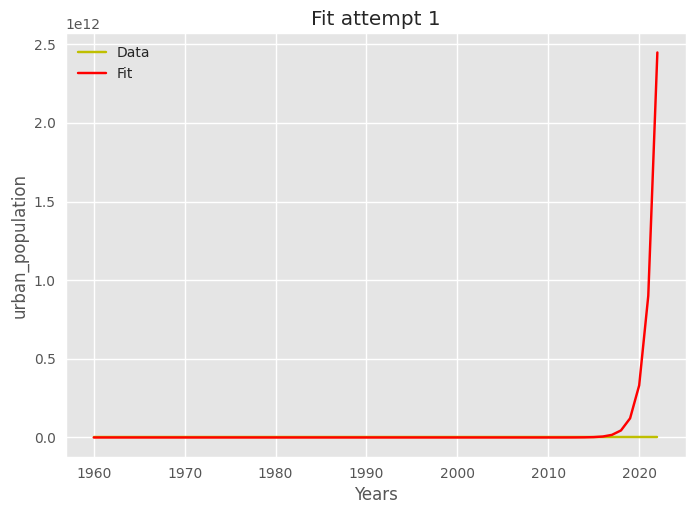

In [82]:
# Plotting the Fitting Attempt Using the values received from the Curve_Fit() and default data

print("Exponential Fit parameter", ur_popt)

# Calling custom plot function defined before to plot the fit model Red & Yellow

fit_plot(ur_pop_stat_can, "Years", "urban_population", "pop_exp", "Years", "urban_population", "Fit attempt 1", 'y', 'r')


#### 10.4.2 Finding a start approximation & Fitting Attempt 2 (setting urban_population parameter ( ur_popt )values)

In [83]:
# Finding the required start value for the time series data
# After many trials The exponential factor  with 4e8 giving better result
# Growth factor of 0.02 is giving a comprimisable fit

ur_popt = [4e8, 0.02]

ur_pop_stat_can["pop_exp"] = exp_growth(ur_pop_stat_can["Years"], *ur_popt)


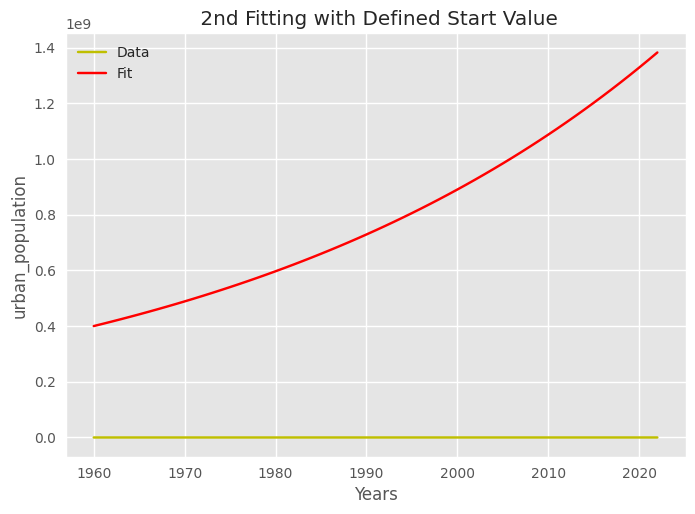

In [84]:
# Calling pre-defined Plotting function for the Fitted Model

fit_plot(ur_pop_stat_can, "Years", "urban_population", "pop_exp", "Years", "urban_population", 
          " 2nd Fitting with Defined Start Value", 'y', 'r')


#### 10.4.3 Final Fitting using Curve_Fit ( by applying the best Fit parameters obtained above)

In [85]:
# fit exponential growth by applying the best Fit parameters obtained above (we use curve_fit for the fitting of exponential model)
ur_popt, co_var = opt.curve_fit(exp_growth, ur_pop_stat_can["Years"], 
                            ur_pop_stat_can["urban_population"], p0=[4e8, 0.02])

ur_pop_stat_can["pop_exp"] = exp_growth(ur_pop_stat_can["Years"], *ur_popt)

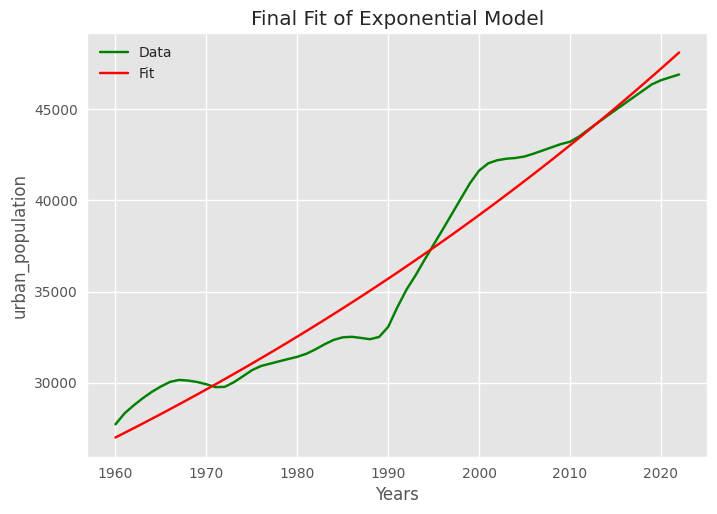

Fit parameter [2.70078853e+04 9.30769320e-03]


In [86]:
# Calling pre-defined Plotting function for the Fitted Model & Displaying Fit Parameters

fit_plot(ur_pop_stat_can, "Years", "urban_population", "pop_exp", "Years", "urban_population", 
         "Final Fit of Exponential Model", 'g', 'r')

print("Fit parameter", ur_popt) 


#### 10.4.4 Finding Exponential Model Error Ranges

In [87]:
# Finding the upper and lower limits of the error ranges using Error Range Funtion
# extracting the sigma value from the Diagonal of the co_variance-Matrix
sigma = np.sqrt(np.diag(co_var))

# Calling the Pre-defined Error Range Funtion to find the error ranges
low, up = err_ranges(ur_pop_stat_can["Years"], exp_growth, ur_popt, sigma)

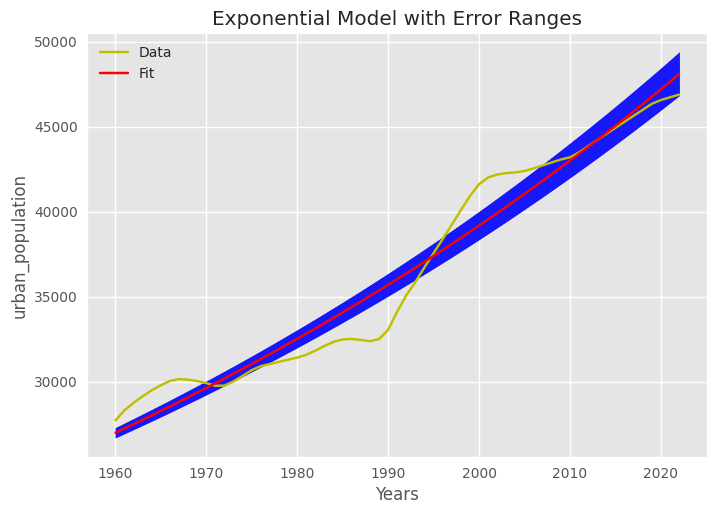

Sigma [2.81917197e+02 2.54707231e-04]


In [88]:
# Calling pre-defined Plotting funtion for the Fitted Model

fit_err_plot(ur_pop_stat_can, low, up, "Years", "urban_population", "pop_exp", "Years", "urban_population", 
             "Exponential Model with Error Ranges", 'y', 'r', 'b')

print("Sigma", sigma)

#### 10.4.5 Forcasting the Data till the year 2050 using Exponential Model

In [89]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year till the year 2050
print("Forcasted urban_population")

low, up = err_ranges(2030, exp_growth, ur_popt, sigma)
print("2030 between ", low, "and", up)

low, up = err_ranges(2040, exp_growth, ur_popt, sigma)
print("2040 between ", low, "and", up)

low, up = err_ranges(2050, exp_growth, ur_popt, sigma)
print("2050 between ", low, "and", up)


Forcasted urban_population
2030 between  50367.42803832388 and 53297.05764561339
2040 between  55139.95319669791 and 58645.16481320091
2050 between  60364.69514029239 and 64529.92919113923


#### 10.4.6 Forcasting the Data till the year 2050 using Exponential Model with Mean & Uncertainity Values

In [90]:
# Printing the Exponenital Model Prediction Uncertainity

print("Forcasted urban_population")
low, up = err_ranges(2030, exp_growth, ur_popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2030:", mean, "+/-", pm)

low, up = err_ranges(2040, exp_growth, ur_popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2040:", mean, "+/-", pm)

low, up = err_ranges(2050, exp_growth, ur_popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2050:", mean, "+/-", pm)

Forcasted urban_population
2030: 51832.24284196863 +/- 1464.8148036447565
2040: 56892.559004949406 +/- 1752.6058082514974
2050: 62447.312165715804 +/- 2082.6170254234203


### 10.5 Fitting with Logistics function Model & Forcasting with Uncertainity values

#### 10.5.1 Finding a start approximation & Improved Fitting

In [91]:
# estimated turning year: 1985 to 2000 , The growth what we have seen in 270 Million that is in 2000, 
# urban_population reaches to 1.05Billion
# urban_population in 1985: about 780 million
# best fitting functions happening with growth factor of 0.05 & exponential value of 8e8 with start value 1985

ur_popt = [2e9, 0.05, 1985]

# Calling the pre defined logistics model function with indicators

ur_pop_stat_can["pop_log"] = logistics(ur_pop_stat_can["Years"], *ur_popt)


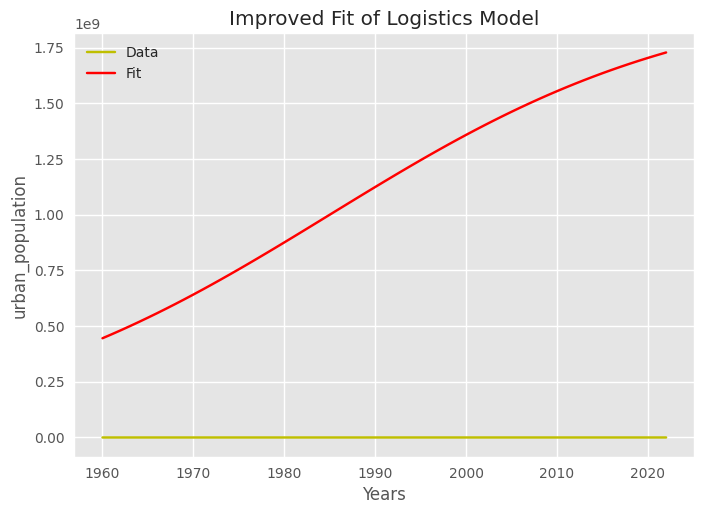

In [92]:
# Calling pre-defined fiting plot
fit_plot (ur_pop_stat_can, "Years", "urban_population", "pop_log", "Years", 
          "urban_population", "Improved Fit of Logistics Model", 'y', 'r')


In [93]:
#For the china urban_population model 3e9 value works better than 2e9 with growth factor of 0.05
ur_popt_chn = [3e9, 0.05, 1985]

# Callign the pre defined logistics model function with indicators
ur_pop_stat_chn["pop_log_chn"] = logistics(ur_pop_stat_chn["Years"], *ur_popt_chn)


#### 10.5.2 Final Fitting using Curve_Fit (  Logistics Model )

In [97]:
# fit logistics model growth by applying the best Fit parameters obtained from above step to teh curve_fit funtion

import scipy.optimize as opt

# Increase maxfev and adjust initial parameters
ur_popt, co_var = opt.curve_fit(logistics, ur_pop_stat_can["Years"], ur_pop_stat_can["urban_population"], 
                                 p0=(1e9, 0.01, 1985), maxfev=10000)

# Apply the model with the fitted parameters
ur_pop_stat_can["pop_log"] = logistics(ur_pop_stat_can["Years"], *ur_popt)


In [98]:
# fitting of data using China
ur_popt_chn, co_var_chn = opt.curve_fit(logistics, ur_pop_stat_chn["Years"], ur_pop_stat_chn["urban_population"], 
                            p0=(2e9, 0.05, 1985))

# Calling Logistics Model Function with ur_popt obtained from the curve fit
ur_pop_stat_chn["pop_log_chn"] = logistics(ur_pop_stat_chn["Years"], *ur_popt_chn)

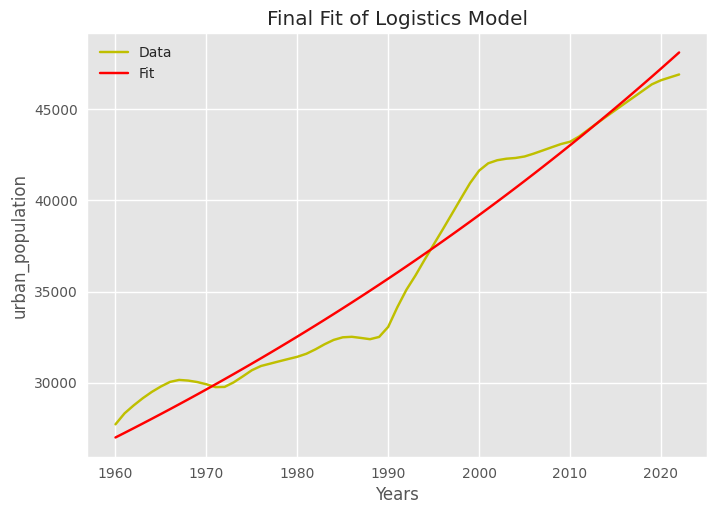

Fit parameter [7.88499473e+08 9.30813413e-03 3.06459604e+03]


In [99]:
fit_plot (ur_pop_stat_can,"Years", "urban_population", "pop_log", "Years", "urban_population",
          "Final Fit of Logistics Model", 'y', 'r')

print("Fit parameter", ur_popt)


#### 10.5.3 Finding Error Ranges ( Logistics Model )

In [100]:
# Finding the upper and lower limits of the error ranges using Error Range Function for India
# extract the sigmas from the diagonal of the co_variance matrix

sigma = np.sqrt(np.diag(co_var))
print(sigma)

# Calling the Pre-defined Error Range Function to find the error ranges in the Logistics Model
low, up = err_ranges(ur_pop_stat_can["Years"], logistics, ur_popt, sigma)


[6.09481291e+12 3.41892828e-03 8.32741235e+05]


In [101]:
# Finding the upper and lower limits of the error ranges using Error Range Function for China
# extract the sigmas from the diagonal of the co_variance matrix

sigma_chn = np.sqrt(np.diag(co_var_chn))
print(sigma_chn)

# Calling the Pre-defined Error Range Function to find the error ranges into the Logistics Model
low_chn, up_chn = err_ranges(ur_pop_stat_chn["Years"], logistics, ur_popt_chn, sigma_chn)

[1.57270552e+08 1.20527136e-03 2.80075598e+00]


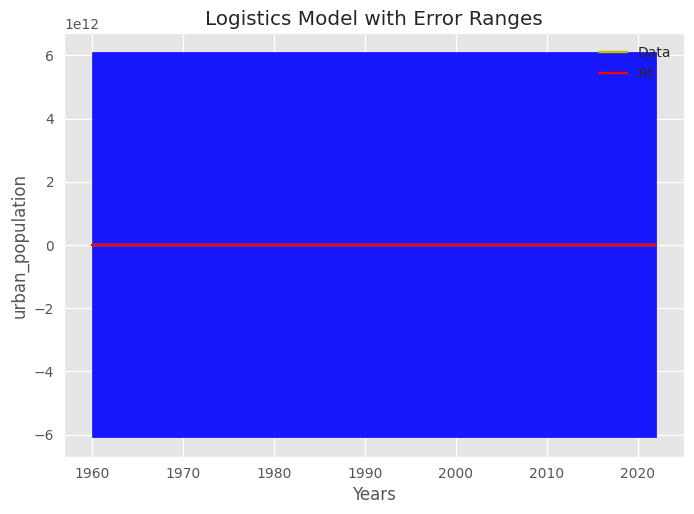

Sigma [6.09481291e+12 3.41892828e-03 8.32741235e+05]


In [102]:
# Calling pre-defined Plotting funtion for the Fitted Model
fit_err_plot(ur_pop_stat_can, low, up, "Years", "urban_population", "pop_log", "Years",
             "urban_population", "Logistics Model with Error Ranges", 'y', 'r', 'b')

print("Sigma", sigma)

#### 10.5.4 Forcasting the Data till the year 2050 ( Logistics Model )

In [103]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year using Logistics Model

print("Forcasted urban_population of India")

low, up = err_ranges(2030, logistics, ur_popt, sigma)
print("2030 between ", low, "and", up)

low, up = err_ranges(2040, logistics, ur_popt, sigma)
print("2040 between ", low, "and", up)

low, up = err_ranges(2050, logistics, ur_popt, sigma)
print("2050 between ", low, "and", up)

Forcasted urban_population of India
2030 between  -6094024412784.807 and 6095601411730.721
2040 between  -6094024412784.807 and 6095601411730.721
2050 between  -6094024412784.807 and 6095601411730.721


In [104]:
# Forcasting the data using on upcoming years with upper & lower limits. ie every next 10 year using Logistics Model
print("Forcasted urban_population of China")
      
low_chn, up_chn = err_ranges(2030, logistics, ur_popt_chn, sigma_chn)
print("2030 between ", low_chn, "and", up_chn)
      
low_chn, up_chn = err_ranges(2040, logistics, ur_popt_chn, sigma_chn)
print("2040 between ", low_chn, "and", up_chn)
      
low_chn, up_chn = err_ranges(2050, logistics, ur_popt_chn, sigma_chn)
print("2050 between ", low_chn, "and", up_chn)

Forcasted urban_population of China
2030 between  970996325.1190058 and 1281604396.2289338
2040 between  1188441011.1048532 and 1533529752.1659284
2050 between  1383663098.4621222 and 1744426064.7759926


#### 10.5.5 Forcasting the Data till the year 2050 using Logistics Model with Mean & Uncertainity Values

In [105]:
print("Forcasted urban_population of India")
low, up = err_ranges(2030, logistics, ur_popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2030:", mean, "+/-", pm)

low, up = err_ranges(2040, logistics, ur_popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2040:", mean, "+/-", pm)

low, up = err_ranges(2050, logistics, ur_popt, sigma)
mean = (up+low)/2.0
pm = (up-low)/2.0
print("2050:", mean, "+/-", pm)

Forcasted urban_population of India
2030: 788499472.9570312 +/- 6094812912257.764
2040: 788499472.9570312 +/- 6094812912257.764
2050: 788499472.9570312 +/- 6094812912257.764


In [106]:
print("Forcasted urban_population of China")
low_chn, up_chn = err_ranges(2030, logistics, ur_popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2030:", mean, "+/-", pm)

low_chn, up_chn = err_ranges(2040, logistics, ur_popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2040:", mean, "+/-", pm)

low_chn, up_chn = err_ranges(2050, logistics, ur_popt_chn, sigma_chn)
mean = (up_chn+low_chn)/2.0
pm = (up_chn-low_chn)/2.0
print("2050:", mean, "+/-", pm)

Forcasted urban_population of China
2030: 1126300360.6739697 +/- 155304035.554964
2040: 1360985381.6353908 +/- 172544370.5305376
2050: 1564044581.6190574 +/- 180381483.15693521


### 10.6 Comparing the Exponential & Logistics Model Result

#### By Analysing the below data, it is evident that the forcasted urban_population by the Logisctics Model far better with lesser uncertainity values than the Exponential Model

#### urban_population Forcast of INDIA

Forcasted urban_population by Exponential Model 
- 2030: 1761142802.478142 +/- 58035361.3904264
- 2040: 2115774968.883082 +/- 75862359.2359544
- 2050: 2541839004.80715 +/- 98514905.2190988

Forcasted urban_population by Logistics Model
- 2030: 1543301431.2071452 +/- 46699966.49086964
- 2040: 1670510746.0098963 +/- 47120391.32927418
- 2050: 1774760904.5372226 +/- 46534203.30912876

#### urban_population Forcast of CHINA

Forcasted urban_population by Logistics Model
- 2030: 1452518112.029258 +/- 11639228.47832489
- 2040: 1481316506.3379145 +/- 10729460.590591788
- 2050: 1500093284.8315427 +/- 9981376.40419054

### 10.7 Plotting the best fitting function and the confidence range

In [107]:
# Defining the envelop for the predicted year including the available year ranges
year_ind = np.arange(1960, 2050)

# Assigning the above created year value with urban_population parameter obtained above to get the forecast shape
forecast_ind = logistics(year_ind, *ur_popt)

In [108]:
# Findign the lower & upper ranges of the envelop using the error range funtion defined before
low_ind, up_ind = err_ranges(year_ind, logistics, ur_popt, sigma)

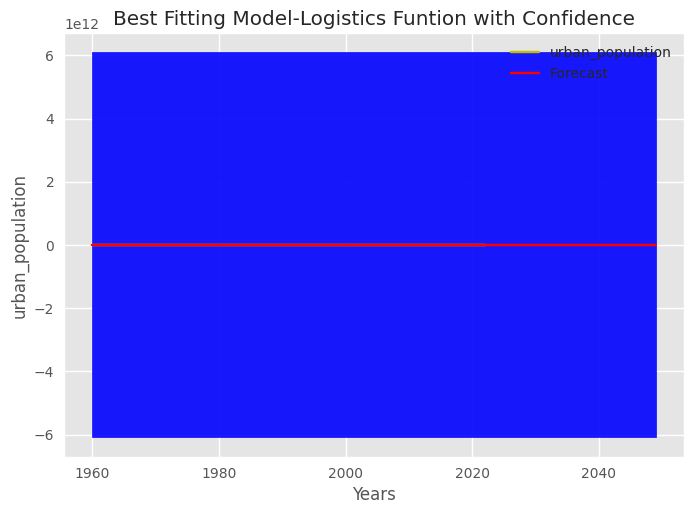

In [109]:
# Calling pre-defined Plotting function for the Fitted Model

best_fit_plot(ur_pop_stat_can, year_ind, forecast_ind, low_ind, up_ind, "Years",
              "urban_population", "Years", "urban_population", "Best Fitting Model-Logistics Funtion with Confidence",
              'y', 'r','b')

In [110]:
# Defining the envelop for the predicted year including the available year ranges
year_chn = np.arange(1960, 2050)

# Assigning the above created year value with urban_population parameter obtained above to get the forecast shape
forecast_chn = logistics(year_chn, *ur_popt_chn)

In [111]:
# Findign the lower & upper ranges of the envelop using the error range funtion defined before
low_chn, up_chn = err_ranges(year_chn, logistics, ur_popt_chn, sigma_chn)

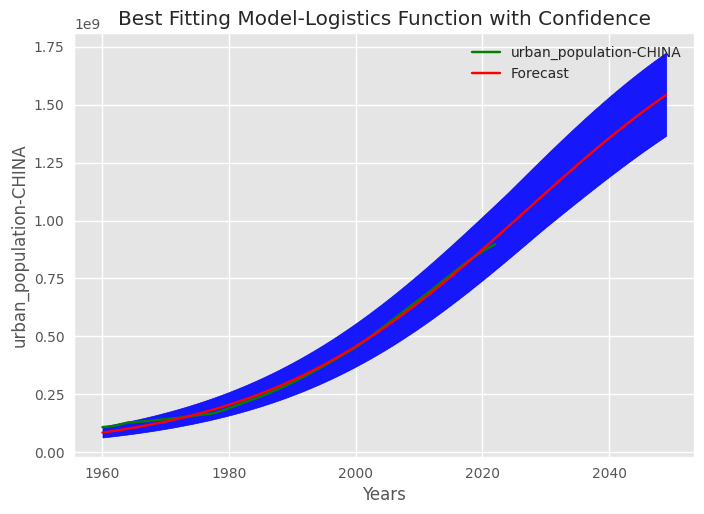

In [112]:
# Calling pre-defined Plotting function for the Fitted Model
best_fit_plot(ur_pop_stat_chn, year_chn, forecast_chn, low_chn, up_chn,
              "Years", "urban_population", "Years", "urban_population-CHINA", "Best Fitting Model-Logistics Function with Confidence",
              'g', 'r', 'b')

# 11. Conclusion

As per the comparitive analysis executed on the two Models ( using Exponential & Logistics funtion) on the section 10, we found out that the Model with Logistics Function producing lessor predictive errors with good confidence value. For this task, we have been using the time series data of INDIA & CHINA. As per our model, the urban_population predictions for the year 2050 has been identified. Below are the details.

- By the start of the year 2050, India will hit the 1.7 billion urban_population mark while the China hits the 1.5 billion urban_population mark



- On the section 9 we did the clustering using K-mean for multiple indicators and produced some interesting analysis. On the seciton 10 we did the Fitting and Prediction using multiple models ( Exponential & Logistics function). Later identified the best fitting model ( Logistics Model) and forcasted the urban_population vlaues of India and China with a good confidence lesser error ranges



- The final poster is created with the data that are analyzed above.